Question 1: (10 points) For visualization purpose, generate heat maps of Reward function 1 and
Reward function 2. For the heat maps, make sure you display the coloring scale. You will have 2 plots
for this questio

In [3]:
import numpy as np
import matplotlib.pyplot as plt


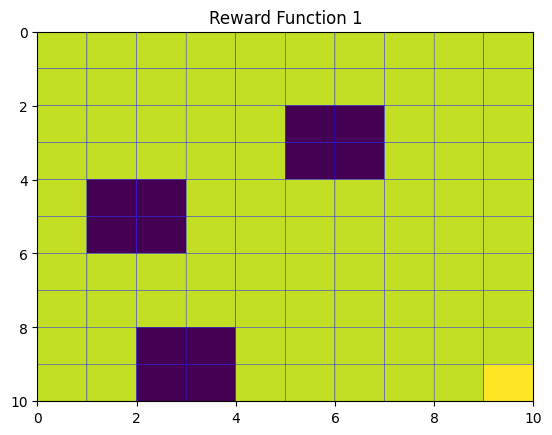

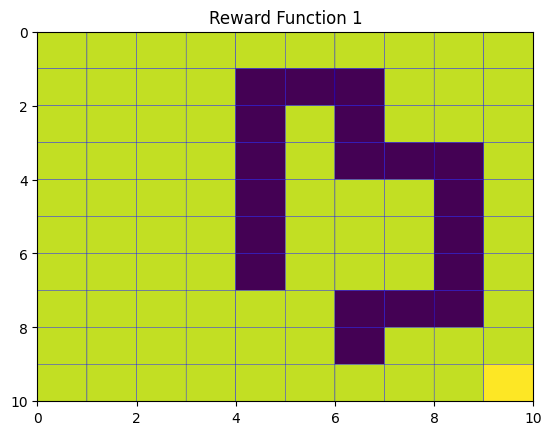

In [11]:
f1 = np.array([[0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,-10,-10,0,0,0], [0,0,0,0,0,-10,-10,0,0,0],[0,-10,-10,0,0,0,0,0,0,0],
         [0,-10,-10,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0],[0,0,-10,-10,0,0,0,0,0,0],[0,0,-10,-10,0,0,0,0,0,1]])

f2 = np.array([[0,0,0,0,0,0,0,0,0,0], [0,0,0,0,-100,-100,-100,0,0,0], [0,0,0,0,-100,0,-100,0,0,0], [0,0,0,0,-100,0,-100,-100,-100,0],[0,0,0,0,-100,0,0,0,-100,0],
         [0,0,0,0,-100,0,0,0,-100,0],[0,0,0,0,-100,0,0,0,-100,0],[0,0,0,0,0,0,-100,-100,-100,0],[0,0,0,0,0,0,-100,0,0,0],[0,0,0,0,0,0,0,0,0,10]])
plt.pcolor(f1,edgecolors='b')
plt.gca().invert_yaxis()
plt.title("Reward Function 1")
plt.show()

plt.pcolor(f2,edgecolors='b')
plt.gca().invert_yaxis()
plt.title("Reward Function 1")
plt.show()

Question 2: (40 points) Create the environment of the agent using the information provided in section
2. To be specific, create the MDP by setting up the state-space, action set, transition probabilities,
discount factor, and reward function. For creating the environment, use the following set of parameters:
• Number of states = 100 (state space is a 10 by 10 square grid as displayed in figure 1)
• Number of actions = 4 (set of possible actions is displayed in figure 2)
• w = 0.1
• Discount factor = 0.8
• Reward function 1